**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [1]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cupy as cp
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

# def f(u, a=2000, b=3000):
# 	'''
# 	Reparametrization mapping function from u -> v
# 	Unconstrained parameter -> Physical parameter space
# 	'''
# 	v = a+(b-a)/(1+np.exp(-u))

# 	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v-a) - np.log(b-v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return tf.cast(log_likelihood, tf.float32)

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return tf.cast(dloglik_dv.flatten() * dv_du.flatten(), tf.float32)

2023-04-01 16:21:55.650893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 16:21:55.878690: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-01 16:21:57.019241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-04-01 16:21:57.019421: W tensorflow/comp

GPU: []


2023-04-01 16:22:04.709867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-01 16:22:04.709932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (himalaya-fon): /proc/driver/nvidia/version does not exist


## Forward modeling

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 104


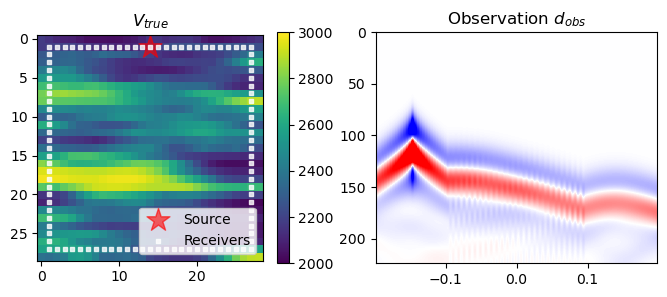

In [2]:
# Model size (nz,nx) = (29,29)
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
# zxrec = zxrec1
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Inversion with prior regularization term

In [3]:
# Define cost function
def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
start = time.time()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = objective_fwi_prior, 
               x0 = u_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_fwi_prior,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 5219.8787 Penalty term = 0.0000 Total loss = 5219.8787 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          841     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21988D+03    |proj g|=  7.52624D+01
Loss (J) = 4351.9518 Penalty term = 0.0024 Total loss = 4351.9543 


 This problem is unconstrained.


Loss (J) = 1810.6726 Penalty term = 0.0607 Total loss = 1810.7332 

At iterate    1    f=  1.81073D+03    |proj g|=  4.27705D+01
Loss (J) = 595.0816 Penalty term = 0.2519 Total loss = 595.3335 

At iterate    2    f=  5.95333D+02    |proj g|=  1.08946D+01
Loss (J) = 457.0142 Penalty term = 0.3136 Total loss = 457.3278 

At iterate    3    f=  4.57328D+02    |proj g|=  6.48796D+00
Loss (J) = 183.2756 Penalty term = 0.4445 Total loss = 183.7200 

At iterate    4    f=  1.83720D+02    |proj g|=  5.30066D+00
Loss (J) = 122.8897 Penalty term = 0.4329 Total loss = 123.3226 

At iterate    5    f=  1.23323D+02    |proj g|=  2.74845D+00
Loss (J) = 65.8208 Penalty term = 0.3852 Total loss = 66.2061 

At iterate    6    f=  6.62061D+01    |proj g|=  2.20776D+00
Loss (J) = 47.5248 Penalty term = 0.3463 Total loss = 47.8712 

At iterate    7    f=  4.78712D+01    |proj g|=  1.82377D+00
Loss (J) = 32.7928 Penalty term = 0.2979 Total loss = 33.0907 

At iterate    8    f=  3.30907D+01    |proj g|=  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 1.1752 Penalty term = 0.1311 Total loss = 1.3062 

At iterate   55    f=  1.30624D+00    |proj g|=  4.32705D-02
Loss (J) = 1.1680 Penalty term = 0.1308 Total loss = 1.2988 

At iterate   56    f=  1.29876D+00    |proj g|=  9.28159D-02
Loss (J) = 1.1492 Penalty term = 0.1296 Total loss = 1.2788 

At iterate   57    f=  1.27878D+00    |proj g|=  2.12165D-01
Loss (J) = 1.1291 Penalty term = 0.1280 Total loss = 1.2570 

At iterate   58    f=  1.25703D+00    |proj g|=  1.57831D-01
Loss (J) = 1.1268 Penalty term = 0.1257 Total loss = 1.2524 

At iterate   59    f=  1.25242D+00    |proj g|=  8.51040D-02
Loss (J) = 1.1122 Penalty term = 0.1249 Total loss = 1.2371 

At iterate   60    f=  1.23709D+00    |proj g|=  7.90309D-02
Loss (J) = 1.1260 Penalty term = 0.1255 Total loss = 1.2515 
Loss (J) = 1.1114 Penalty term = 0.1249 Total loss = 1.2363 

At iterate   61    f=  1.23626D+00    |proj g|=  8.55771D-02
Loss (J) = 1.0790 Penalty term = 0.1259 Total loss = 1.2049 

At iterate   62 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 2.7906 Penalty term = 0.1263 Total loss = 2.9169 
Loss (J) = 0.7465 Penalty term = 0.1261 Total loss = 0.8726 

At iterate   67    f=  8.72585D-01    |proj g|=  4.76562D-02
Loss (J) = 0.7400 Penalty term = 0.1261 Total loss = 0.8661 

At iterate   68    f=  8.66059D-01    |proj g|=  6.21104D-02
Loss (J) = 0.7289 Penalty term = 0.1260 Total loss = 0.8549 

At iterate   69    f=  8.54896D-01    |proj g|=  1.10511D-01
Loss (J) = 0.7311 Penalty term = 0.1261 Total loss = 0.8572 
Loss (J) = 0.7243 Penalty term = 0.1260 Total loss = 0.8503 

At iterate   70    f=  8.50285D-01    |proj g|=  4.83350D-02
Loss (J) = 0.7162 Penalty term = 0.1261 Total loss = 0.8423 

At iterate   71    f=  8.42266D-01    |proj g|=  2.21117D-02
Loss (J) = 0.7081 Penalty term = 0.1261 Total loss = 0.8342 

At iterate   72    f=  8.34160D-01    |proj g|=  3.72952D-02
Loss (J) = 0.6840 Penalty term = 0.1261 Total loss = 0.8101 

At iterate   73    f=  8.10067D-01    |proj g|=  5.81363D-02
Loss (J) = 0.6517


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## FWI result

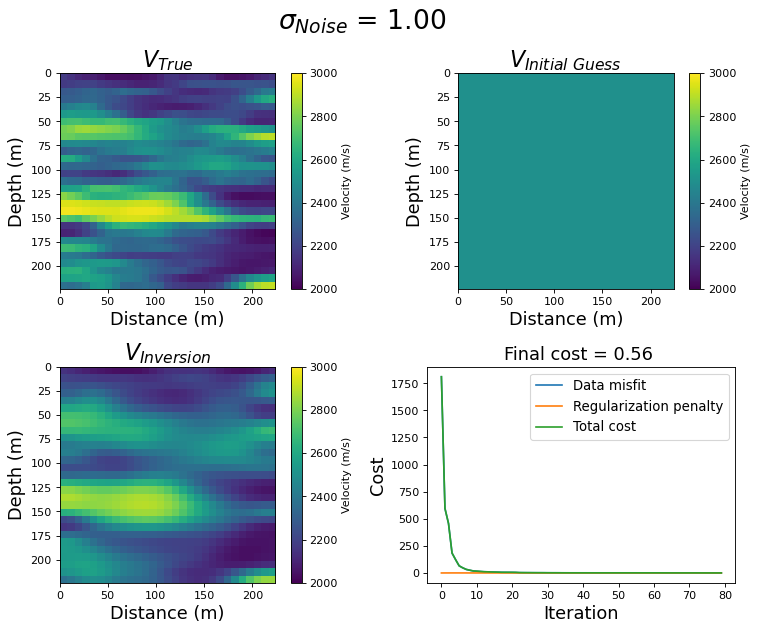

In [6]:
# Plot deterministic FWI result and optimization history
v_fwi = f(u_fwi)

plt.figure(figsize=(10,8),dpi=80)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# SVGD

In [44]:
import multiprocessing

def compute_loglik_fn(u):
    # your implementation of loglik_fn here
    return loglik_fn(u.numpy(),d_obs,*args)
    # return -0

def compute_dloglik_du_fn(u):
    # your implementation of dloglik_du_fn here
    return dloglik_du_fn(u.numpy(),d_obs,*args)

def compute_parallel(u_samples, num_processes=4):
    with multiprocessing.Pool(processes=num_processes) as pool:
        log_likelihoods = pool.map(compute_loglik_fn, u_samples)
        grads_log_likelihoods = pool.map(compute_dloglik_du_fn, u_samples)
    return log_likelihoods, grads_log_likelihoods

args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Define the prior distribution for the model parameters
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
prior_scale_tril = tf.cast(tf.linalg.cholesky(prior_cov), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=prior_mean, scale_tril=prior_scale_tril)
prior_scale = p_dist.stddev()

# Define the TensorFlow variables for the variational posterior particles
num_particles = 841 * 10
q_particles_init = tf.random.normal(shape=(num_particles, nz*nx), dtype=tf.float32)
q_particles = tf.Variable(q_particles_init, dtype=tf.float32)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
misfit_history = []

optimizer = tf.keras.optimizers.Adam()

# Set hyper-parameters
std_noise = 1
optimizer.learning_rate = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
num_iters = 50
alpha = 5  # learning rate for updating the particles

Learning Rate: 0.10000000149011612


In [12]:
for i in range(num_iters):
  # Print the iteration number
  print(f"Iteration {i + 1}/{num_iters}", end="    ")
  
  with tf.GradientTape() as tape:
    # Watch the parameters of the variational posterior
    tape.watch(q_particles)
    
    ## Compute the SVGD kernel matrix and its gradient
    rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=1.0)
    svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)

    q_mean = tf.reduce_mean(q_particles, axis=0)
    q_cov = tfp.stats.covariance(q_particles) + 1e-5 * tf.eye(nz*nx, dtype=tf.float32)
    if tf.linalg.det(q_cov)==0: print(" * Warning: Numerically Unstable    det(q_cov)=0")
    q_dist = tfp.distributions.MultivariateNormalTriL(q_mean, tf.linalg.cholesky(q_cov))
    misfit = J(f(q_mean.numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    print("J = %.2f" % misfit)
    misfit_history.append(misfit)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []

    # Calculate the gradient of the log-likelihoods
    log_likelihoods, grads_log_likelihoods = compute_parallel(q_particles, num_processes=8)
    # for u in q_particles:
    #   log_likelihoods.append(loglik_fn(u.numpy(), d_obs, *args))
    #   grads_log_likelihoods.append(dloglik_du_fn(u.numpy(), d_obs, *args))

    # Compute E[log likelihood] and its gradient
    E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
    grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods, axis=0), dtype=tf.float32)

    # Compute the KL(q||p) term 
    kl_divergence_q_p = tfp.distributions.kl_divergence(q_dist, p_dist)
    grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, q_particles)
    
    # Compute the SVGD update for each particle
    svgd_update = (tf.matmul(svgd_kernel_matrix, grads_log_likelihoods) + grads_kl_divergence_q_p) / tf.cast(num_particles, dtype=tf.float32)
    
    # Apply the SVGD update to the particles
    # q_particles = tf.Variable(q_particles + alpha * svgd_update)
    optimizer.apply_gradients(zip([svgd_update], [q_particles]))

    # Clip the particle positions to avoid NaNs
    # q_particles = tf.clip_by_value(q_particles, -1e4, 1e4)
    

Iteration 1/50    J = 5203.77
Iteration 2/50    J = 5171.50
Iteration 3/50    J = 5139.43
Iteration 4/50    J = 5107.54
Iteration 5/50    J = 5075.86
Iteration 6/50    J = 5044.37
Iteration 7/50    J = 5013.07
Iteration 8/50    J = 4981.97
Iteration 9/50    J = 4951.06
Iteration 10/50    J = 4920.35
Iteration 11/50    J = 4889.83


KeyboardInterrupt: 

In [43]:
# q_particles = tf.Variable(q_particles)
# # svgd_update = tf.Variable(svgd_update)
# tf.Variable(q_particles + alpha * svgd_update)

# Apply the SVGD update to the particles
q_particles = tf.Variable(q_particles + alpha * svgd_update)
svgd_update = (tf.matmul(svgd_kernel_matrix, grads_log_likelihoods) + grads_kl_divergence_q_p) / tf.cast(num_particles, dtype=tf.float32)

optimizer.apply_gradients(zip([svgd_update], [q_particles]))

q_particles

InvalidArgumentError: {{function_node __wrapped____MklMatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} In[1] ndims must be >= 2 [Op:MatMul]

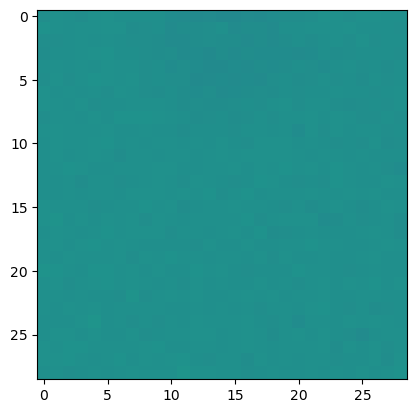

In [18]:
vmin, vmax = f(u_ref).min(), f(u_ref).max()
plt.imshow(f(q_mean.numpy()).reshape((nz,nx)),vmin=vmin, vmax=vmax)

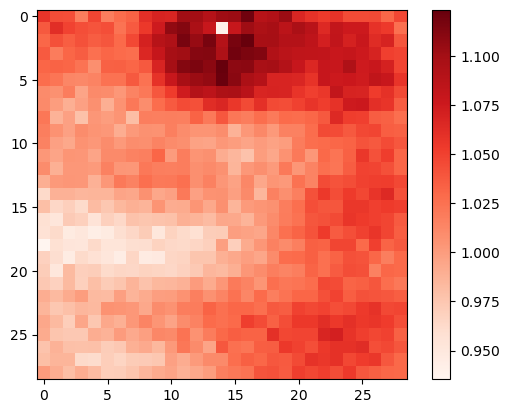

In [10]:
plt.imshow(tf.reshape(q_dist.stddev(),[nz,nx]),cmap='Reds')
plt.colorbar()

In [232]:
# Define the TensorFlow variables for the variational posterior particles
num_particles = 100
q_particles_init = tf.random.normal(shape=(num_particles, nz*nx), dtype=tf.float32)
q_particles = tf.Variable(q_particles_init, dtype=tf.float32)

## Compute the SVGD kernel matrix and its gradient
rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=1.0)
svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)

# Add a small jitter term to make the matrix numerically stable
jitter = 1e-6
num_particles = 100
svgd_kernel_matrix += jitter * tf.eye(num_particles)

tf.linalg.cholesky(svgd_kernel_matrix)


<tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[0.99993944, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.0000005 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.0000005 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.0000005 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.0000005 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.0000005 ]], dtype=float32)>

In [123]:
# Exapmle code
for i in range(num_iters):
  # Print the iteration number
  print(f"Iteration {i + 1}/{num_iters}")
  
  with tf.GradientTape() as tape:
    # Watch the parameters of the variational posterior
    tape.watch(q_particles)
    
    # Compute the SVGD kernel matrix and its gradient
    q_gradients = tape.gradient(q_particles, q_particles)
    # svgd_kernel_matrix = svgd_kernel(q_particles, q_gradients)
    rbf_kernel = tfp.math.psd_kernels.RBF(length_scale=1.0)
    svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)
    grads_svgd_kernel_matrix = tape.gradient(svgd_kernel_matrix, q_particles)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []
        
    # Compute the gradient of u with respect to the particles
    with tf.GradientTape() as tape2:
      tape2.watch(q_particles)
      u_samples = q_particles
      du_dq = tape2.gradient(u_samples, q_particles)
    
    # Calculate the gradient of the log-likelihoods
    for u in u_samples:
      log_likelihoods.append(loglik_fn(u.numpy(), d_obs, *args))
      grads_log_likelihoods.append(dloglik_du_fn(u.numpy(), d_obs, *args))
    
    # Compute E[log likelihood] and its gradient
    E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
    grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods, axis=0) * du_dq, dtype=tf.float32)

    # Compute the KL(q||p) term 
    kl_divergence_q_p = tfp.distributions.kl_divergence(
        tfp.distributions.MultivariateNormalDiag(loc=q_particles, scale_diag=q_scale), p_dist)
    grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, q_particles)



Iteration 1/5


AttributeError: module 'tensorflow_probability.python.math.psd_kernels' has no attribute 'RBF'